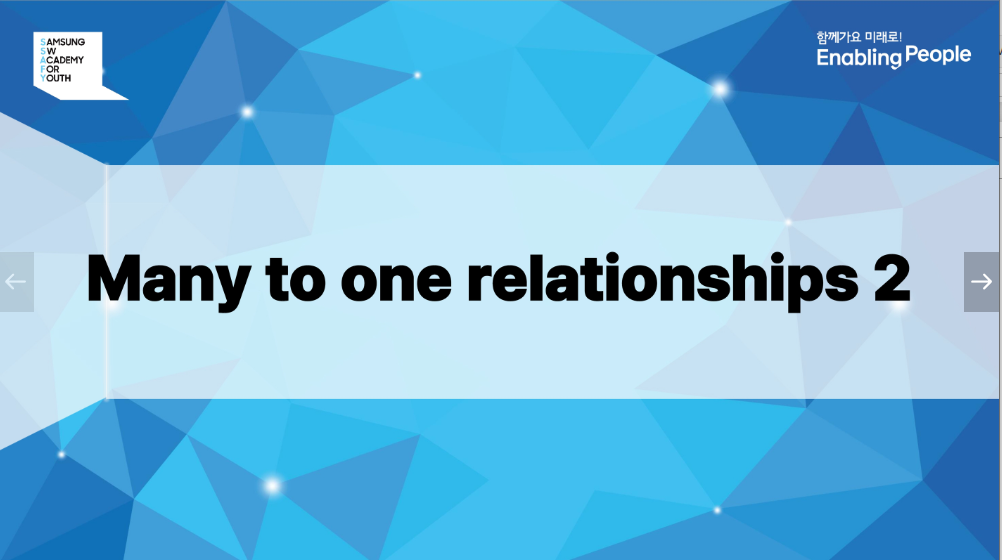

 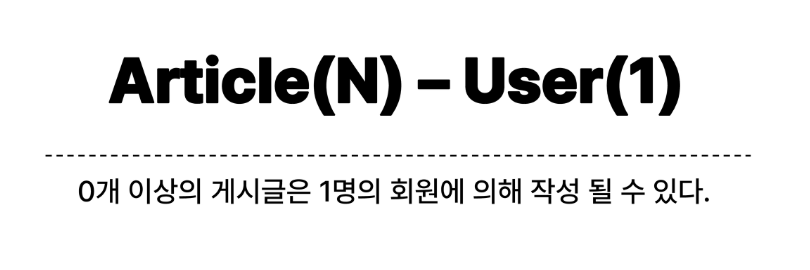

article - comment = 1 : N
article - user = N : 1  (외래키 - article에 생김)
comment - user = N : 1  


# > Article(N) - User(1)

## - 게시글 생성

Article 에 user 외래키 추가 - ForeignKey( to, )
이때 참고할 user이 accounts의 models의 모듈에 존재함 - import

```
from accounts.models import User
from django.conf import settings
from django.contrib.auth import get_user_model
```
이때 , 
```
user = models.ForeignKey(User, on_delete=models.CASCADE)
이
user = models.ForeignKey(settings.AUTH_USER_MODEL, on_delete=models.CASCADE)
로 바꿈!
```
* AUTH_USER_MODEL - 우리가 setting의 맨 마지막에 넣어준 account.User 값

### WHY??
=> 우리는 User class를 직접 참고하지 않음! - accunts User폼도 직접 참고하지 않았음
장고는 유저모델에 대한 직접참고를 싫어함 - 나중에 유저모드가 변경사항이 생겼을 때 모든 참고 코드에 대해 바꾸어 주어야하기 때문에 자동으로 추적해서 변경해주는 함수모델을 사용하는것임!

```
user = models.ForeignKey(get_user_model, on_delete=models.CASCADE)
```
로 사용해도 상관없음
but, settings.AUTH_USER_MODEL를 사용할 것임!!

=> why? 
get_user_model() = 함수   / 객체
settings.AUTH_USER_MODEL = 그냥 값     / 문자열

runserver 할 때 models.py가 구동이 될 때 User객체가 장고에 없을 수도 있어서 오류가 날 수 있음 = 임의로 문자열로 넣어놓음


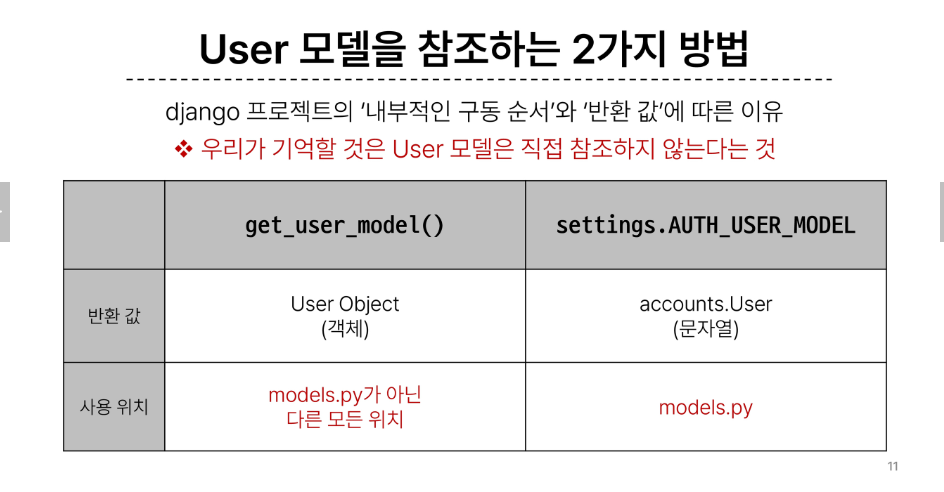

### User 모델은 직접 참조하지 않는다!!

*** User객체 참조할 때 문자열(settings.AUTH_USER_MODEL) 쓰는 경우 - models.py에서 밖에 없음!

이 때 python manage.py makemigrations 를 하면 에러가 남
=> 새로운 행? 을 만들기 때문에 기본값을 어떻게 할 것인지 물어봄
-> 1 누르기 -> 정수값 넣어주기(아무 정수) 

=> 기존의 게시글들의 user 값이 1이 되는것!



게시글에서 user 값 빼줌 - forms.py 에서 필드값을 수정하거나 exclude를 해주면 됨

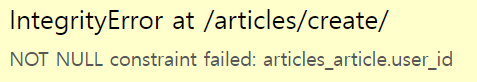

이 때 ararticles_article  -> 테이블 이름    user_id  -> 필드의 이름
즉, 이곳에 Null 값이 들어오고 있어서 나는 오류
=> 즉, 게시글의 작성자가 없다는 것 but, 현재 로그인한 user가 작성자여야함
-> view의 create에서 그냥 save 하는 것이 아니라, article.user = 현재 로그인 된 유저
라고 지정해 준 뒤 save해주어야 한다
이때, article.user = 현재 로그인 된 유저 라고 지정해주려면 1.저장이 안되어야하고, 2. article instance 가 필요함 => save(commit=False) 가 필요!! 
즉, 저장은 안하고 결과값은 보내줌

현재 로그인된 정보 는 어디에?? = request에 user라는 존재가 있음 (이미 사용중임)
```
article = form.save(commit=False)
article.user = request.user
form.save()
```

** article.save() 와 form.save() 차이
article.save는 form의 생성, 수정을 구분하지 못해서 instance의 유무로 구분했지만
form.save는 자동으로 구분가능




## - 게시글 조회

index or detail 에 작성자 보이기 -> article.user 혹은 article.user.username 씀


## - 게시글 수정
게시글 수정 요청 사용자와 게시글작성 사용자를 비교하여 본인의 게시글만 수정할 수 있도록 하기

```
def update(request, pk):
    article = Article.objects.get(pk=pk)
    if request.method == 'POST':
        form = ArticleForm(request.POST, instance=article)
        if form.is_valid:
            form.save()
            return redirect('articles:detail', article.pk)
    else:
        form = ArticleForm(instance=article)
    context = {
        'article': article,
        'form': form,
    }
    return render(request, 'articles/update.html', context)
```

에서 request.user == article.user 인지 먼저 확인해주기
```
def update(request, pk):
    article = Article.objects.get(pk=pk)
    if request.user == article.user:
        if request.method == 'POST':
            form = ArticleForm(request.POST, instance=article)
            if form.is_valid:
                form.save()
                return redirect('articles:detail', article.pk)
        else:
            form = ArticleForm(instance=article)
    else:
        return redirect('articles:index')
    context = {
        'article': article,
        'form': form,
    }
    return render(request, 'articles/update.html', context)
```
즉, if 본인의 게시글이면 글 수정, else이면 index로 가기

Q. 수정할 땐 commit=False 필요없음 -> 이미 유저정보가 있기때문에 필요없음!

+ detail페이지에서도 if문으로 수정이 보이지 않게 해줌


## - 게시글 삭제

```
def delete(request, pk):
    article = Article.objects.get(pk=pk)
    if request.user == article.user:
        article.delete()
    return redirect('articles:index')
```

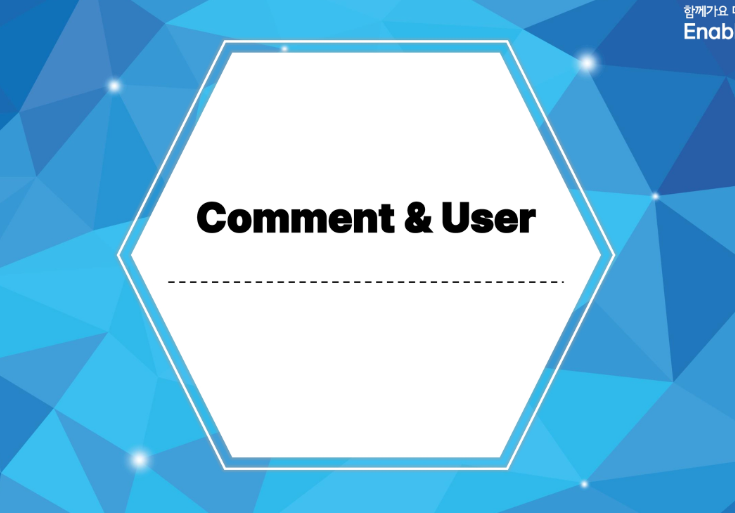

models.py 의 Comment 클래스에 외래키 추가!!

user = models.ForeignKey(settings.AUTH_USER_MODEL, on_delete=models.CASCADE)
만 넣어주면 됨~ + migration 해주기



- 댓글 작성

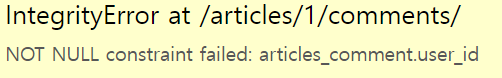

> 댓글의 작성자가 보내지지 않았기 때문에 에러남@
forms에서 commentForm을 수정해주어야함 => view에서 댓글이 생성될 때(comments_create) 작성자 정보 받아주기
즉, comment.user = request.user 추가!! 

- 댓글 조회

>출력할 때 작성자와 함께 출력하기
 {{comment.user}} : {{ comment.content }}


- 댓글 삭제

> 댓글 삭제 요청자와 사용자를 비교하여 본인의 댓글만 삭제할 수 있도록하기

(comments_delete)에서 if comment.user == request.user: 넣어주기 + detail 페이지에서도 본인이 아니면 삭제버튼이 안보이게 해주기


